```accel-realapps-ann-runtime-single.ipynb```
#    <font color='red'>Study Title: Performance-Aware Energy-Efficient GPU Frequency Selection using DNN-based Models</font>

> ***venue:*** Accepted at 52nd International Conference on Parallel Processing (ICPP) 2023

> ***Authors:*** Ghazanfar ALI *and* Mert SIDE

<hr style="border:2px solid gray">


***README***

First three code cells are used to include the needed libraries, sets global variables, and define shared functions. Please run them before running anything else


___
### IMPORT LIBRARIES AND SET GLOBAL VARIABLES

In [1]:
#!/usr/bin/python3

# IMPORT LIBRARIES AND SET GLOBAL VARIABLES ----------------------------------

# GENERIC
import sys
import statistics
import itertools
import datetime as dt
from os import error
from typing_extensions import runtime

# NUMPY
import numpy as np
from numpy.lib import type_check
from numpy.core.fromnumeric import mean

# PANDAS
import pandas as pd

# MATPLOTLIB
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as plticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import Normalize
from matplotlib.offsetbox import (TextArea, 
                                  DrawingArea, 
                                  OffsetImage, 
                                  AnnotationBbox)
from matplotlib.patches import Rectangle

# SEABORN
import seaborn as sns
from seaborn.palettes import color_palette

# SKLEARN
import sklearn
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.utils import shuffle

# MISC.
# from xgboost import XGBRegressor

xss = 6
ss  = 7   # 8
ms  = 8   # 10
ls  = 9   # 12
xls = 14
xxls = 16

matplotlib.rc('xtick', labelsize=ss) 
matplotlib.rc('ytick', labelsize=ss) 

figureExtension = '.pdf'
# figureExtension = '.png'
# figureExtension = '.svg'
preferredDPI = 400
# ============================================================================

___
### Set global color, hatch and marker standards

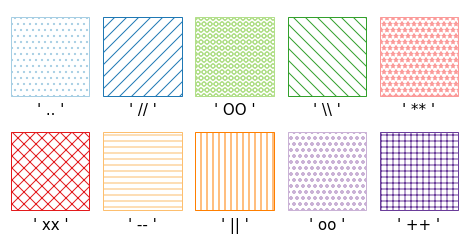

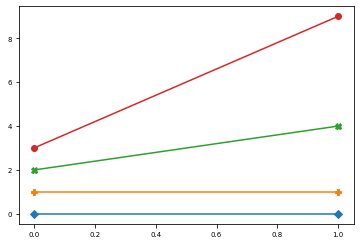

In [2]:
# DEMO hatches ===============================================================
fig, axs = plt.subplots(2, 5, constrained_layout=True, figsize=(6.4, 3.2),
                        facecolor='white')

# SWATCHES -------------------------------------------------------------------
baseColors  = sns.color_palette("Paired")
baseHatches = ['..', '//', 'OO', '\\\\', '**', 'xx', '--', '||', 'oo', '++'] # ['oo', 'xx', '++', '//', '\\\\', '--', '||', '..', '**', 'OO']
baseMarkers = ['D', 'P', 'X', 'o'] # ['o', 'X', 'P', 'D']
alternateColors = ['r', 'g', 'b', 'm', 'y', 'c']
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

markerSize = 50

baseLineColor = 'deeppink'
baseLinewidth = 2
baseArrowColor = 'tomato'
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---
# https://matplotlib.org/stable/api/markers_api.html

# colors = itertools.cycle(['r','g', 'b', 'm', 'y', 'c'])
# MARKERS ['o', '+', '*', '.', 'x', '_', '|', 's', 'd', '^', 'v', 
#          '>', '<', 'p', 'h', 'X', '8', '1', '2',',','P']

colors=itertools.cycle(baseColors)
hatches=itertools.cycle(baseHatches)
markers=itertools.cycle(baseMarkers)

def hatches_plot(ax, h):
    ax.add_patch(Rectangle((0, 0), 2, 2, fill=False, hatch=h, color=next(colors)))
    ax.text(1, -0.5, f"' {h} '", size=15, ha='center')
    ax.axis('equal')
    ax.axis('off')

for ax, h in zip(axs.flat, hatches):
    hatches_plot(ax, h)
   
plt.show()

plt.close()

i = 0
for m in baseMarkers:
    plt.plot([i, i*i], marker=next(markers))
    i = i + 1
# END OF DEMO hatches ========================================================

___
### Global Functions

In [3]:
def learning_curve(hist):
    
    plt.plot(hist.history['mean_absolute_percentage_error'])
    plt.title('Model Error')
    plt.ylabel('MAPE')
    plt.xlabel('Epoch')
    # plt.legend(['Train', 'Val'], loc='lower right')
    plt.grid(True)
    plt.show()
    
    '''
    plt.plot(hist.history['loss'], label='loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()
    '''
    print (min(hist.history['mean_absolute_percentage_error']))

In [4]:

def pltdata (y_test,y_pred):           
            
    plt.figure()
    plt.plot(y_test, color = 'red', label = 'Real data')
    plt.plot(y_pred, color = 'blue', label = 'Predicted data')
    #                 plt.title('Prediction')
    plt.legend()
    plt.grid(True)
    # plt.savefig('runtime_measured_pred_'+app+'.pdf')
    plt.show()
    plt.close()


In [5]:

def predict_data(hist):
  
    apps = ['NAMD','LAMMPS','GROMACS','LSTM']
    for app in apps:
        print ('************',app,'************')
    #     f = 'GA100-dvfs-'+app+'-dcgm.csv'
        f = 'GA100_am_energy_rt_pwr_'+app+'.csv'
        dat = pd.read_csv(f)    
        if model_name == 'n_run_time':
            dat[model_name] = dat['run_time'].div(max(dat['run_time']))
        dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'].div(2)) 

        df2 = dat[['fp_active','dram_active','sm_app_clock',model_name]]
        df2 = df2.copy()
        dataset2 = df2.values
        X_test = dataset2[:, :-1]
        y_test = dataset2[:, -1]
        X_test = sc.transform(X_test)
        pltdata (X_test,y_test,hist)

___
___
___


In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import tensorflow as tf

from keras.layers import Dropout
from keras import regularizers
from sklearn.metrics import mean_absolute_percentage_error

# SWATCHES -------------------------------------------------------------------
colors  = itertools.cycle(baseColors[0:2])
hatches = itertools.cycle(baseHatches)
markers = itertools.cycle(baseMarkers)
marker_size = markerSize
#  ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---   ---

'''
# opt = tf.keras.optimizers.SGD(learning_rate=0.01)
# opt = tf.keras.optimizers.Adam(learning_rate=0.002) # with elu (time)
# opt = tf.keras.optimizers.Adadelta(learning_rate=0.01)
# opt = tf.keras.optimizers.Adagrad(learning_rate=0.01)
# opt = tf.keras.optimizers.Adamax(learning_rate=0.01) #  with tanh (power)
# opt = tf.keras.optimizers.Nadam(learning_rate=0.01)
# opt = tf.keras.optimizers.Ftrl(learning_rate=0.01)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.01) # with relu (time)
'''

SPEC_dataPath = "../datasets/SPEC_A100/"
dgemm_Stream_DataPath = "../datasets/dgemm_stream/"
HPC_DataPath = "../datasets/"

models = ['power_usage','n_run_time']
# act_funcs = ['sigmoid','relu','softmax','softplus','softsign','selu', 'tanh', 'elu']
act_funcs = ['selu']

# opts = [tf.keras.optimizers.Adam(),tf.keras.optimizers.Adamax(),tf.keras.optimizers.Nadam(),tf.keras.optimizers.RMSprop()]
opts = [tf.keras.optimizers.RMSprop()]
model_name = 'n_run_time'
df_list = []
app_acc_list = {'NAMD':[],'LAMMPS':[],'GROMACS':[],'LSTM':[],'BERT':[],'ResNet50':[],'SPECFEM3D':[],'DGEMM':[],'STREAM':[]}
f = SPEC_dataPath + 'GA100-dvfs-accel-dcgm.csv'
df = pd.read_csv(f)

df['fp_active'] = df['fp64_active'].add(df['fp32_active'].div(2))

if model_name == 'n_run_time':
    df_l = []
    hpc_apps = ["nw", "kmeans", "ge","tpacf","histo", "cutcp", "srad", "bfs", "spmv", "mriq","stencil","lbm", "bplustree", "fft", "cfd", "lud", "heartwall","lavamd", "hotspot"]
    for hpc_app in hpc_apps:
        hpc_app_df = df.loc[df['application'] == hpc_app]
        hpc_app_df = hpc_app_df.copy()
        hpc_app_df[model_name] = hpc_app_df['run_time'].div(max(hpc_app_df['run_time']))
        df_l.append(hpc_app_df)
    del df
    df = pd.concat(df_l)

apps = ['dgemm','stream']
for app in apps:
    f = dgemm_Stream_DataPath + 'GA100-dvfs-'+app+'-dcgm.csv'
    dat = pd.read_csv(f)    
    if model_name == 'n_run_time':
        dat[model_name] = dat['run_time'].div(max(dat['run_time']))
        
    if app == 'dgemm':
        dat['fp_active'] = dat['tensor_activity']
    elif app == 'stream':
        dat['fp_active'] = dat['fp64_active']
    df_list.append(dat)
df_list.append(df)
data1 = pd.concat(df_list)
data1['n_sm_app_clock'] = data1['sm_app_clock'].div(max(data1['sm_app_clock']))
    
df1 = data1[['fp_active','dram_active','n_sm_app_clock',model_name]]
df1 = df1.copy()
dataset1 = df1.values
X_train = dataset1[:, :-1]
y_train = dataset1[:, -1]

# Feature Scaling
from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
import datetime

app_ind = 0
generate_data = 1
# for model in models:
for act_func in act_funcs:
    for opt in opts:
        print (act_func, opt)
        # epocs = 25
        # for s in [8,15,0,28]: #GA100 25
        # epocs = 35
        # for s in [17,17,15,13]: #GA100 35
        # epocs = 36
        # for s in [1,0,8,4]: #GA100 36
        
        epocs = 25
        # for s in [28,26,0,28]: #GV100 25
        # epocs = 36
        for s in [1,1,5,8,8,6,2,3,1]: #GV100 35
        # epocs = 36
        # for s in [12,25,8,8]: #GV100 36
            from numpy.random import seed
            seed(s)
            tf.random.set_seed(s+1)
            print (s,s+1)
            # '''
            # Initialising the ANN
            model = Sequential()

            neurans = 64
           
            model.add(Dense(neurans, activation = act_func, input_dim = 3))

            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal'))

            model.add(Dense(units = neurans, activation = act_func,kernel_initializer='lecun_normal')) #
            
            # Adding the output layer
            model.add(Dense(units = 1))

            model.compile(optimizer=opt,
                          loss='mean_squared_error',
                          metrics=['mean_absolute_percentage_error'])
            start_time = datetime.datetime.now()
            hist = model.fit(X_train, y_train,
                      batch_size=64, epochs=epocs,verbose=0) # ,validation_split = 0.2    
            end_time = datetime.datetime.now()
            time_diff = (end_time - start_time)
            print('execution_time =', time_diff.total_seconds())

            # predict_data(hist)

            apps = ['NAMD','LAMMPS','GROMACS','LSTM','DGEMM','STREAM','ResNet50','BERT','SPECFEM3D']
            # apps = ['GROMACS','LAMMPS','LSTM','NAMD','BERT','ResNet50','SPECFEM3D','DGEMM','STREAM']
            # apps = ['NAMD']
            # for app in apps:
            app = apps[app_ind]
            app_ind += 1
            print ('************',app,'************')
            '''
            # f = HPC_DataPath + 'GA100-ml-pwr-'+app+'.csv'
            # f = HPC_DataPath + 'v100/GV100-ml-pwr-'+app+'.csv'
            f = HPC_DataPath + 'v100/GV100-dvfs-'+app+'-dcgm.csv'
            dat = pd.read_csv(f)    
            if model_name == 'n_run_time':
                dat[model_name] = dat['run_time'].div(max(dat['run_time']))
            dat['fp_active'] = dat['fp64_active'].add(dat['fp32_active'].div(2))
            dat['n_sm_app_clock'] = dat['sm_app_clock'].div(max(dat['sm_app_clock']))
            '''
            # f = HPC_DataPath + 'GA100-ml-pwr-'+app+'.csv'
            # max_freq = 1410
            # freq_count = 61
            # f = HPC_DataPath + 'v100/GV100-ml-pwr-'+app+'.csv'
            # max_freq = 1380
            # freq_count = 117

            pwr_f = HPC_DataPath + 'mi210/MI210-ml-pwr-'+app+'.csv'
            # rprof_f = HPC_DataPath + 'agg/rocprof/rocprof-MI210-dvfs-'+app+'-agg.csv'
            time_f = HPC_DataPath + 'agg/time/MI210-dvfs-'+app+'-perf.csv'
            # max_freq = 1410
            freq_count = 3
            # d1 = pd.read_csv(rsmi_f)
            d2 = pd.read_csv(time_f)
            dat = pd.read_csv(pwr_f)

            # dat['sm_app_clock'] = d1['sclk']
            dat['run_time'] = d2['time']
            # new dram_active
            def_dram_act = dat[dat['dvfs_level']==2]['MemUnitBusy'].iloc[0]
            dat['dram_active'] = [(def_dram_act/100) for i in range(freq_count)]
            # new fp_active
            def_fp32_act = dat[dat['dvfs_level']==2]['SALUBusy'].iloc[0]
            def_fp64_act = dat[dat['dvfs_level']==2]['VALUBusy'].iloc[0]
            def_fp_act = def_fp64_act + (def_fp32_act)
            dat['fp_active'] = [(def_fp_act/100) for i in range(freq_count)] 
            dat['n_sm_app_clock'] = dat['sm_app_clock'].div(max(dat['sm_app_clock']))
            dat[model_name] = dat['run_time'].div(max(dat['run_time']))

            df2 = dat[['fp_active','dram_active','n_sm_app_clock',model_name]]
            df2 = df2.copy()
            dataset2 = df2.values
            X_test = dataset2[:, :-1]
            y_test = dataset2[:, -1]
            # X_test = sc.transform(X_test)

            y_pred = model.predict(X_test)
            if generate_data != 0:  
                dat['predicted_n_run_time'] = y_pred
                dat['energy'] = dat['run_time'].mul(dat['power_usage'])
                dat['n_energy'] =  dat['n_run_time'].mul(dat['power_usage'])
                dat['predicted_n_energy'] =  dat['predicted_n_run_time'].mul(dat['predicted_power_usage'])
                dat.reset_index(inplace=True)  
                # dat.to_csv(HPC_DataPath + 'GA100-ml-energy-rt-pwr-'+app+'.csv',index=False)
                # dat.to_csv(HPC_DataPath + '/v100/GV100-ml-energy-rt-pwr-'+app+'.csv',index=False)
                dat.to_csv(HPC_DataPath + '/mi210/mi210-ml-energy-rt-pwr-'+app+'.csv',index=False)
        
            acc = round(100-100*mean_absolute_percentage_error (y_test,y_pred),1)
            app_acc_list[app].append(acc)
            print (acc)
            # if generate_data != 0:
            pltdata (y_test,y_pred)           
            
                
print (app_acc_list)

selu <keras.optimizers.optimizer_experimental.rmsprop.RMSprop object at 0x12a6ce4d0>
1 2
execution_time = 1.352632
************ GROMACS ************


KeyError: "['n_sm_app_clock'] not in index"

In [10]:
#35:
# d = {'NAMD': [91.99, 96.31, 72.15, 76.19, 93.39, 88.59, 73.41, 75.59, 85.89, 79.64, 86.18, 83.32, 93.65, 74.48, 88.47, 91.01, 95.68, 79.68, 87.15, 63.24, 94.34, 87.23, 86.0, 75.07, 95.45, 97.35, 92.8, 87.46, 91.16, 73.97], 'LAMMPS': [93.5, 95.88, 94.32, 78.15, 76.05, 79.47, 89.17, 91.66, 94.7, 93.24, 70.04, 83.63, 97.08, 59.66, 90.7, 91.29, 96.83, 93.04, 91.93, 95.2, 75.19, 68.15, 77.52, 90.39, 95.93, 91.49, 93.36, 76.37, 94.14, 95.99], 'GROMACS': [69.55, 80.09, 51.38, 70.27, 74.77, 73.57, 82.38, 51.53, 67.08, 57.58, 72.21, 62.84, 80.69, 88.53, 76.01, 71.18, 74.34, 55.34, 68.64, 92.45, 75.56, 72.97, 68.1, 93.58, 74.09, 75.92, 72.75, 76.29, 68.03, 51.58], 'LSTM': [84.7, 91.86, 61.48, 75.17, 85.45, 96.26, 67.64, 58.53, 86.79, 73.11, 88.93, 78.83, 93.49, 94.75, 95.18, 89.78, 92.71, 66.02, 88.29, 60.43, 87.55, 88.71, 89.15, 78.8, 90.85, 92.72, 87.35, 94.54, 85.64, 62.36]}
# d = {'NAMD': [82.2, 92.1, 84.4, 73.2, 77.5, 87.7, 60.9, 91.6, 94.5, 82.2, 94.1, 83.6, 89.4, 63.2, 65.8, 94.0, 92.1, 84.7, 85.6, 37.4, 90.4, 80.0, 90.1, 55.5, 90.3, 85.4, 93.1, 87.6, 88.2], 'LAMMPS': [91.7, 88.9, 71.5, 42.5, 31.7, 81.8, 43.6, 69.3, 60.6, 80.7, 87.1, 61.7, 76.9, 16.2, 49.7, 73.9, 50.1, 54.2, 51.0, 27.8, 44.3, 91.6, 77.5, 35.4, 91.4, 48.5, 72.8, 70.2, 69.1], 'GROMACS': [75.0, 80.4, 75.1, 71.2, 74.9, 78.4, 66.6, 78.4, 78.3, 73.1, 77.6, 91.7, 87.0, 72.8, 74.8, 86.3, 82.1, 75.2, 73.3, 51.2, 79.0, 71.1, 81.1, 66.0, 82.0, 86.9, 79.7, 86.0, 78.6], 'LSTM': [70.7, 88.3, 57.0, 81.7, 82.6, 79.2, 80.4, 59.8, 83.3, 60.8, 81.3, 76.5, 88.1, 95.8, 95.8, 84.6, 86.0, 56.6, 82.4, 66.7, 80.7, 76.1, 78.8, 82.8, 74.4, 86.7, 79.2, 83.8, 85.6]}

# '''
namd = app_acc_list['NAMD']
print('NAMD: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['LAMMPS']
print('LAMMPS: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['GROMACS']
print('GROMACS: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['LSTM']
print('LSTM: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['SPECFEM3D']
print('SPECFEM3D: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['BERT']
print('BERT: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['ResNet50']
print('ResNet50: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['DGEMM']
print('DGEMM: ',namd.index(max(namd)),max(namd))

namd = app_acc_list['STREAM']
print('STREAM: ',namd.index(max(namd)),max(namd))
# '''

# REAL APPS GA100:
# NAMD:  1 97.4
# LAMMPS:  0 97.0
# GROMACS:  8 98.7
# LSTM:  4 96.7
# EPOCH 1000 GA100:
# NAMD:  17 96.1
# LAMMPS:  4 97.7
# GROMACS:  24 98.3
# LSTM:  23 94.3
# EPOCH 200
# NAMD:  15 96.8
# LAMMPS:  19 97.5
# GROMACS:  16 95.7
# LSTM:  3 95.2
# EPOCH 1500
# NAMD:  8 97.6
# LAMMPS:  4 98.2
# GROMACS:  3 96.1
# LSTM:  18 96.2
## EPOCH 2000
# NAMD:  19 97.6
# LAMMPS:  23 98.6
# GROMACS:  2 92.6
# LSTM:  20 94.8


NAMD:  0 82.1
LAMMPS:  0 64.9
GROMACS:  0 94.2
LSTM:  0 98.9
SPECFEM3D:  0 82.9
BERT:  0 96.5
ResNet50:  0 94.8
DGEMM:  0 95.4
STREAM:  0 94.2


In [9]:
NAMD:  0 92.7
LAMMPS:  0 77.7
GROMACS:  0 94.1
LSTM:  0 95.1
NAMD:  0 93.5
LAMMPS:  0 98.4
GROMACS:  0 94.2
LSTM:  0 96.8
LSTM:  0 94.5

SyntaxError: invalid syntax (3972877861.py, line 1)